In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [3]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import matplotlib.pyplot as plt
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'
base_path = './data'
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'

In [27]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder, label):
    plt.figure(figsize=(15, 15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img_bgr = cv2.imread(image_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, 3, i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img, norm=no_norm)

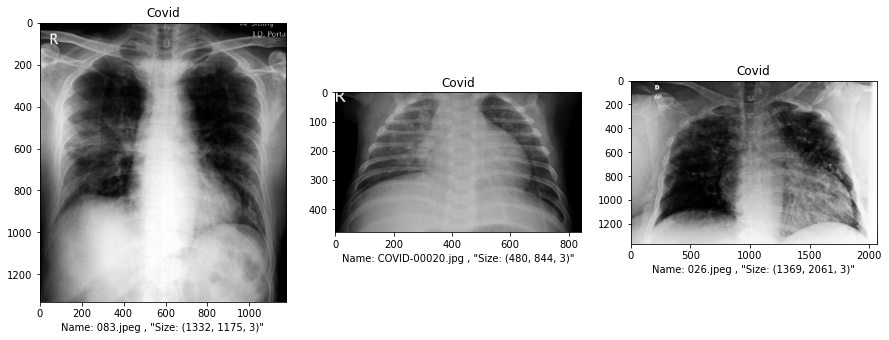

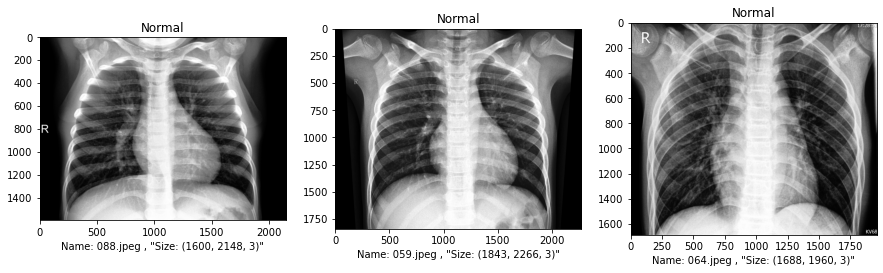

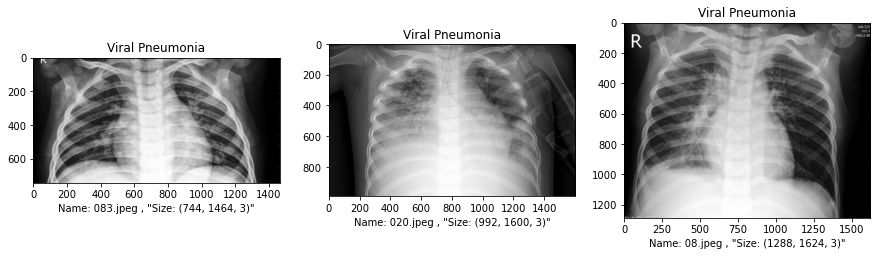

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [25]:
for func in [lambda: os.mkdir(os.path.join(base_path, classic_folder)),
             lambda: os.mkdir(os.path.join(base_path, synthetic_folder)),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'test')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'test'))
            ]:
    try:
        func()
    except Exception as error:
        print(error)
        continue

[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic\\train'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic\\test'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic\\train'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic\\test'


In [30]:
for label in labels:
    os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'test'), label))
    os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'train'), label))
    os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'test'), label))
    os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'train'), label))